# RL MC

In [1]:
import numpy as np
import gym
import time 
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from functools import partial

In [2]:
gym.__file__

'/Users/carloscardona/opt/anaconda3/envs/RL/lib/python3.9/site-packages/gym/__init__.py'

In [2]:
def EpsilonGreedyPolicy(Q, epsilon, state):
    # The smaller the epsilon the greedier the agent:
    if np.random.random() > epsilon: 
        return np.argmax(Q[state]) 
    else:
        #action = np.random.randint(0, env.action_space.n) 
        return  np.random.randint(0, env.action_space.n) 


In [9]:
# monte carlo 
class MC(object):
    def __init__(self, env, num_states, num_actions, gamma=1, eps=0.1, eps_decay=0.9999, first_visit=True,
                  render=True, max_iter=100000):
        self.env=env
        self.num_states = num_states
        self.num_actions = num_actions
        self.first_visit = first_visit

        self.gamma = gamma
        self.eps = eps
        self.eps_decay = eps_decay
        self.max_iter=max_iter
        self.render=render

        self.Q = np.random.uniform(low = -1, high = 1, 
                          size =(self.num_states, self.num_actions))
        self.Q_num = np.zeros((self.num_states, self.num_actions))
        self.visited_num = np.zeros((self.num_states, self.num_actions))
    ###################################################################################################
        # one episode containing max_iterations (200 is the max of iteration in the montaincar by default)
    def update_Q(self):
        
        obs = self.env.reset()    
        policy = partial(EpsilonGreedyPolicy, self.Q, self.eps)

        rewards = []
        actions = []
        states = []
    
        for _ in range(self.max_iter):
            state_idx = []
            flatten_index=0
            for ob, lower, upper, num in zip(obs, lower_bounds, upper_bounds, num_states):
                state =int(num * (ob - lower) / (upper- lower) )
                if state >= num:
                    state = num - 1
                if state < 0:
                    state = 0
                state_idx.append(state)

            flatten_index=np.ravel_multi_index(state_idx, num_states)
        
            action = policy(flatten_index)
            
            # save state and action taken in this step
            actions.append(action)
            states.append(flatten_index)

            if self.render:
                env.render()
                #time.sleep(0.03)
            # take an action    
            [obs, reward, done, info] = env.step(action)
            # Save the reward after the action has been taken
            rewards.append(reward)

            if done:
                break
        ############################################################################
        updated_states = set()
        discounted_rewards=scipy.signal.lfilter([1],[1,-self.gamma], np.array(rewards)[::-1], axis=0)[::-1]
        
        for state, action, disc_rew in zip(states, actions, discounted_rewards):

            if self.first_visit:
                if state in updated_states:
                    continue

                updated_states.add(state)

            # incremental averaging
            
            # count the number of state-=action pairs visited in this episode
            self.Q_num[state, action] += 1
            
            # compute the average aproximation for the Q-tensor from this episode
            self.Q[state, action] += (disc_rew - self.Q[state, action]) / self.Q_num[state, action]
            self.visited_num[state, action] += 1
            rewards_in_episode= np.sum(np.array(rewards))

        self.eps *= self.eps_decay

        return rewards_in_episode, self.Q



<font color='blue'> <font size=4> By default, the montain-car enviroment is capped at 200 iterations by episode, which is not ideal for Monte Carlo, which computes a better average for greater samples per episode. This is because by the law of large numbers, the average reward of a given episode will get closer to the actual average the larger the sample space. To increase the number of iteration in a single episode, we can use a nice feature of open ai gym, which is the "register", that allow us to alter some default parameters of the enviorements and define our own: </font>

In [4]:
gym.envs.register(
    id='MountainCarExtraLong-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=500,
    reward_threshold=475.0,
)

In [10]:
#load the enviroment
env = gym.make('MountainCarExtraLong-v0')

# define the (to be discretized) action-state space
num_actions = env.action_space.n   # number of actions of the enviroment, in montain car we have
                                   # three actions, acelerate left, right and not acelerate. 
num_states = [36, 28]              # number of discrete states we want. This can be chance, but increasing it will
                                   # also increase the computation cost. 
lower_bounds = np.array([-12, -7]) # lower value for the position and the velocity (don't mind the units :P)
upper_bounds = np.array([6, 7])    # upper value for the position and the velocity


state_space_dim = np.prod(np.array(num_states)) # dimension of the state space

#  MC(env, num_states, num_actions, gamma=1, eps=0.1, eps_decay=0.9999, first_visit=True,
#                  render=True, max_iter=100000):
mc = MC(env,state_space_dim , num_actions,eps=0.3, first_visit=True)

num_episodes = 100

for i in range(num_episodes):
    rewards_in_episode, Q= mc.update_Q()
    print("Iteration " + str(i) + " reward: " + str(rewards_in_episode))
    print("Average regards" + str(rewards[i]) )
env.close()

2021-10-08 12:42:13.356 python[74035:2091204] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd0b78b53e0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-10-08 12:42:13.357 python[74035:2091204] Warning: Expected min height of view: (<NSButton: 0x7fd0b8f70430>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-10-08 12:42:13.361 python[74035:2091204] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd0ba926710>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2021-10-08 12:42:13.363 python[74035:2091204] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fd0b816e1a0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


Iteration 0 reward: -500.0
Average regards0.0
Iteration 1 reward: -500.0
Average regards0.0
Iteration 2 reward: -500.0
Average regards0.0
Iteration 3 reward: -500.0
Average regards0.0
Iteration 4 reward: -500.0
Average regards0.0
Iteration 5 reward: -500.0
Average regards0.0
Iteration 6 reward: -500.0
Average regards0.0
Iteration 7 reward: -500.0
Average regards0.0
Iteration 8 reward: -500.0
Average regards0.0
Iteration 9 reward: -500.0
Average regards0.0
Iteration 10 reward: -500.0
Average regards0.0
Iteration 11 reward: -500.0
Average regards0.0
Iteration 12 reward: -413.0
Average regards0.0
Iteration 13 reward: -500.0
Average regards0.0
Iteration 14 reward: -500.0
Average regards0.0
Iteration 15 reward: -500.0
Average regards0.0
Iteration 16 reward: -500.0
Average regards0.0
Iteration 17 reward: -500.0
Average regards0.0
Iteration 18 reward: -500.0
Average regards0.0
Iteration 19 reward: -500.0
Average regards0.0
Iteration 20 reward: -500.0
Average regards0.0
Iteration 21 reward: -5

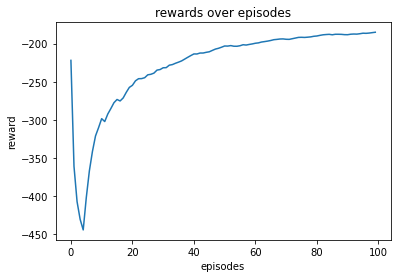

In [13]:
plt.plot(rewards)
plt.title('rewards over episodes')
plt.xlabel('episodes')
plt.ylabel('reward')
plt.show()

In [15]:
# with open('test.npy', 'wb') as f:
#     np.save(f, np.array([1, 2]))
#     np.save(f, np.array([1, 3]))
# with open('test.npy', 'rb') as f:
#     a = np.load(f)
#     b = np.load(f)
with open('Q_MC_1.npy', 'wb') as f:
    np.save(f, Q)

<font color='blue'> <font size=4>Now that we have a succeding version of the Q-tensor, we can just loaded and use without need to running the whole Monte Carlo computation again. </font>

In [1]:
import numpy as np
import gym
import time 
from functools import partial

gym.envs.register(
    id='MountainCarExtraLong-v0',
    entry_point='gym.envs.classic_control:MountainCarEnv',
    max_episode_steps=500,
    reward_threshold=475.0,
)
env = gym.make('MountainCarExtraLong-v0')

def EpsilonGreedyPolicy(Q, epsilon, state):

    if np.random.random() > epsilon: # CC. Given an epsilon, if epsilon is smaller than a randoom number 
                                         # between 0 and 1
        return np.argmax(Q[state]) 
    else:
        #action = np.random.randint(0, env.action_space.n) 
        return  np.random.randint(0, env.action_space.n) 

In [2]:
with open('Q_MC_1.npy', 'rb') as f:
    Q = np.load(f)

In [14]:
import time

num_steps = 2000

obs = env.reset()

num_actions = env.action_space.n
num_states = [36, 28]
lower_bounds = np.array([-12, -7])
upper_bounds = np.array([6, 7])

for _ in range(num_steps):
    state_idx = []
    flatten_index=0
    for ob, lower, upper, num in zip(obs, lower_bounds, upper_bounds, num_states):
        state =int(num * (ob - lower) / (upper- lower) )
        if state >= num:
            state = num - 1
        if state < 0:
            state = 0
        state_idx.append(state)
    
    flatten_index=np.ravel_multi_index(state_idx, num_states)
    policy = partial(EpsilonGreedyPolicy, Q, 0)
    action = policy(flatten_index)
    # apply the action
    obs, reward, done, info = env.step(action)
    
    # Render the env
    env.viewer = None
    env.render()

    # Wait a bit before the next frame unless you want to see a crazy fast video
    time.sleep(0.001)
    
    # If the epsiode is up, then start another one
    if done:
        obs= env.reset()